In [3]:
import astropy.coordinates as c
import astropy.units as u
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np

from ctapipe.coordinates import CameraFrame, EngineeringCameraFrame, TelescopeFrame
from ctapipe.image import hillas_parameters, tailcuts_clean, toymodel
from ctapipe.instrument import SubarrayDescription, CameraDescription, CameraGeometry
from ctapipe.visualization import CameraDisplay

from IPython.display import display, HTML,Image
from matplotlib.animation import FuncAnimation

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

# Getting the HESS Camera geometry

In [7]:
# Get camera geometries

## Flashcam camera needs to be rotated by 90deg
FlashCam_geom = CameraGeometry.from_name('FlashCam')
FlashCam_geom.pix_rotation = 90*u.deg

In [12]:
## Pixel numbering/ pixel position is different between simtelerray and HAP
hap1u_pix_pos =np.loadtxt("PixelPositions/1U_PixPos.dat")

HessIU_geom = CameraGeometry.from_name('HESS-I')
HessIU_geom.pix_id, HessIU_geom.pix_x, HessIU_geom.pix_y = hap1u_pix_pos[:,0],hap1u_pix_pos[:,1]*u.m,hap1u_pix_pos[:,2]*u.m
HessIU_geom.pix_rotation = 90*u.deg

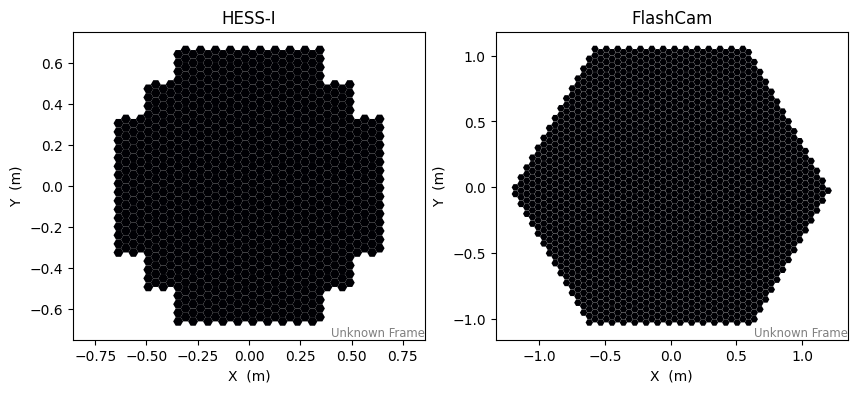

In [13]:
f,ax=plt.subplots(nrows=1, ncols=2, figsize=(10,4))
CameraDisplay(HessIU_geom, ax=ax[0])
CameraDisplay(FlashCam_geom)
plt.show()

# Displaying an Event

My work-around to not use HAP for displaying images is using a C-Script for writing out the pixel information

In [14]:
def Df_PixelData(filename="", mcdata=False):
    columnnames = ["Event_loop_id","BunchNr","EventNr","TelId","PixID","MCEnergy","MCCoreX","MCCoreY","PixAmplitude","PixTime"]
    pixel_data = np.loadtxt(filename)
    return pd.DataFrame(pixel_data,columns=columnnames)

def DisplayEvent(DF_PixelData, eventloop_id, colormap="jet", highlight_cleaned_pixels=False, HillasParameters=False):
    if highlight_cleaned_pixels:
        colormap = "twilight"
    
    Df_Event = DF_PixelData.iloc[DF_PixelData.Event_loop_id.to_numpy() == eventloop_id]
    fEventNr, fMCEnergy, fCoreX, fCoreY = Df_Event.EventNr.drop_duplicates().values[0],Df_Event.MCEnergy.drop_duplicates().values[0], Df_Event.MCCoreX.drop_duplicates().values[0],Df_Event.MCCoreY.drop_duplicates().values[0]
    print(" Event {}:".format(fEventNr))
    print(" -----> MC Energy = {:f} TeV, CorePoint = ({:f},{:f}) m".format(fMCEnergy,fCoreX,fCoreY))
    triggered_tels = Df_Event.TelId.drop_duplicates().values
    
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(nrows=2, ncols=3)
    gs_space = np.array([gs[0, 0],gs[1, 0],gs[0, 1],gs[1, 1],gs[0:, 2]])

    for tel_id in range(1,6):
        triggered_mask = (triggered_tels == tel_id)
        if np.count_nonzero(triggered_mask)==0:
            if tel_id == 5:
                ax = fig.add_subplot(gs_space[tel_id-1])
                disp=CameraDisplay(FlashCam_geom, ax=ax, title = "CT5-Flashcam")
                disp.cmap =colormap
                disp.add_colorbar()
            else:
                ax = fig.add_subplot(gs_space[tel_id-1])
                disp=CameraDisplay(HessIU_geom, ax=ax,title = "CT%s HESS-1U"%tel_id)
                disp.cmap =colormap
                disp.add_colorbar()
        else:
            df_Telescope = Df_Event.iloc[Df_Event.TelId.to_numpy()==tel_id]
            if tel_id == 5:
                image=np.zeros(FlashCam_geom.pix_id.shape[0])
                image[df_Telescope.PixID.to_numpy().astype(int)]=df_Telescope.PixAmplitude.to_numpy()
                
                ax = fig.add_subplot(gs_space[tel_id-1])
                disp=CameraDisplay(FlashCam_geom,image=image, ax=ax, title= "CT5-Flashcam")
                disp.cmap =colormap
                disp.add_colorbar()
                if(highlight_cleaned_pixels):
                    mask =(image > 0)
                    disp.highlight_pixels(mask, alpha=0.5, color="dodgerblue")
                
                if(HillasParameters):
                    clean_image = image.copy()
                    hillas = hillas_parameters(FlashCam_geom, clean_image)
                    disp.overlay_moments(hillas, color="red", linewidth=1.5, with_label=True)
                
            else:
                image=np.zeros(HessIU_geom.pix_id.shape[0])
                image[df_Telescope.PixID.to_numpy().astype(int)]=df_Telescope.PixAmplitude.to_numpy()
                
                ax = fig.add_subplot(gs_space[tel_id-1])
                disp=CameraDisplay(HessIU_geom,image=image, ax=ax,title = "CT%s HESS-1U"%tel_id)
                disp.cmap =colormap
                disp.add_colorbar()
                if(highlight_cleaned_pixels):
                    mask =(image > 0)
                    disp.highlight_pixels(mask, alpha=0.5, color="dodgerblue")
                    
                if(HillasParameters):
                    clean_image = image.copy()
                    hillas = hillas_parameters(HessIU_geom, clean_image)
                    disp.overlay_moments(hillas, color="red", linewidth=1.5, with_label=True)
                

       
            


In [15]:
DfPixelData = Df_PixelData(filename="385_PixelInfo_eventwise.dat")

 Event 324308.0:
 -----> MC Energy = 0.023138 TeV, CorePoint = (127.947000,-40.595900) m


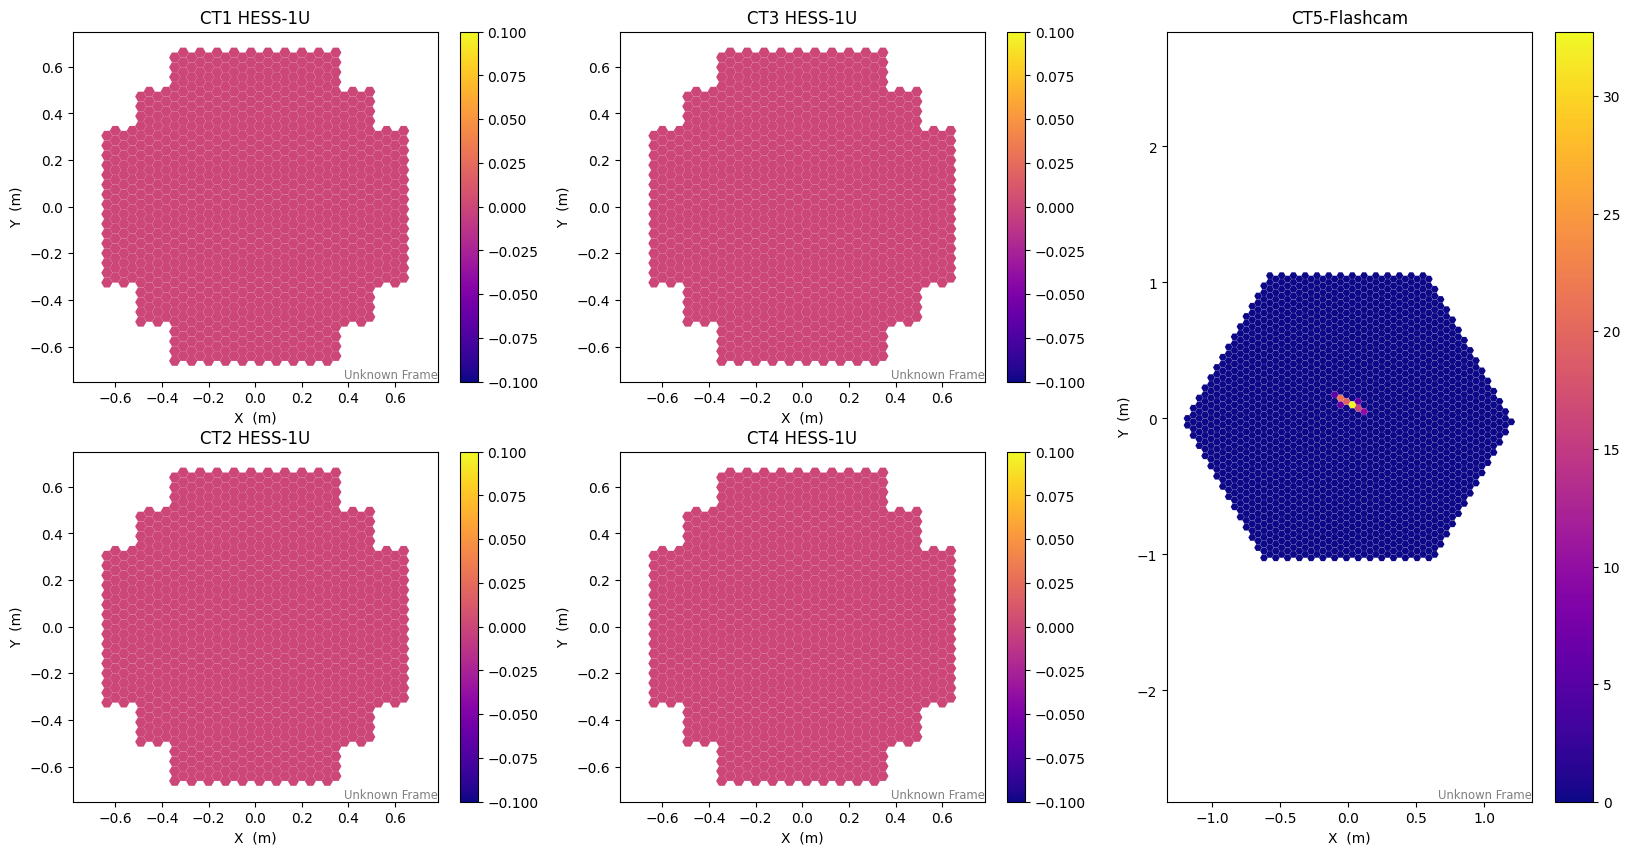

In [16]:
DisplayEvent(DfPixelData, 300, colormap="plasma")

# Play around

In [17]:
## Looking for nice images -> near the telescopes and high energy events

emin=4
emask = (DfPixelData.MCEnergy.to_numpy()>=emin)
EnergyCut = DfPixelData.iloc[emask]
print("Events above %f TeV: "%emin+str(EnergyCut.MCEnergy.drop_duplicates().shape[0]))

Events above 4.000000 TeV: 6


 Event 161203.0:
 -----> MC Energy = 19.959800 TeV, CorePoint = (266.028000,-65.064300) m


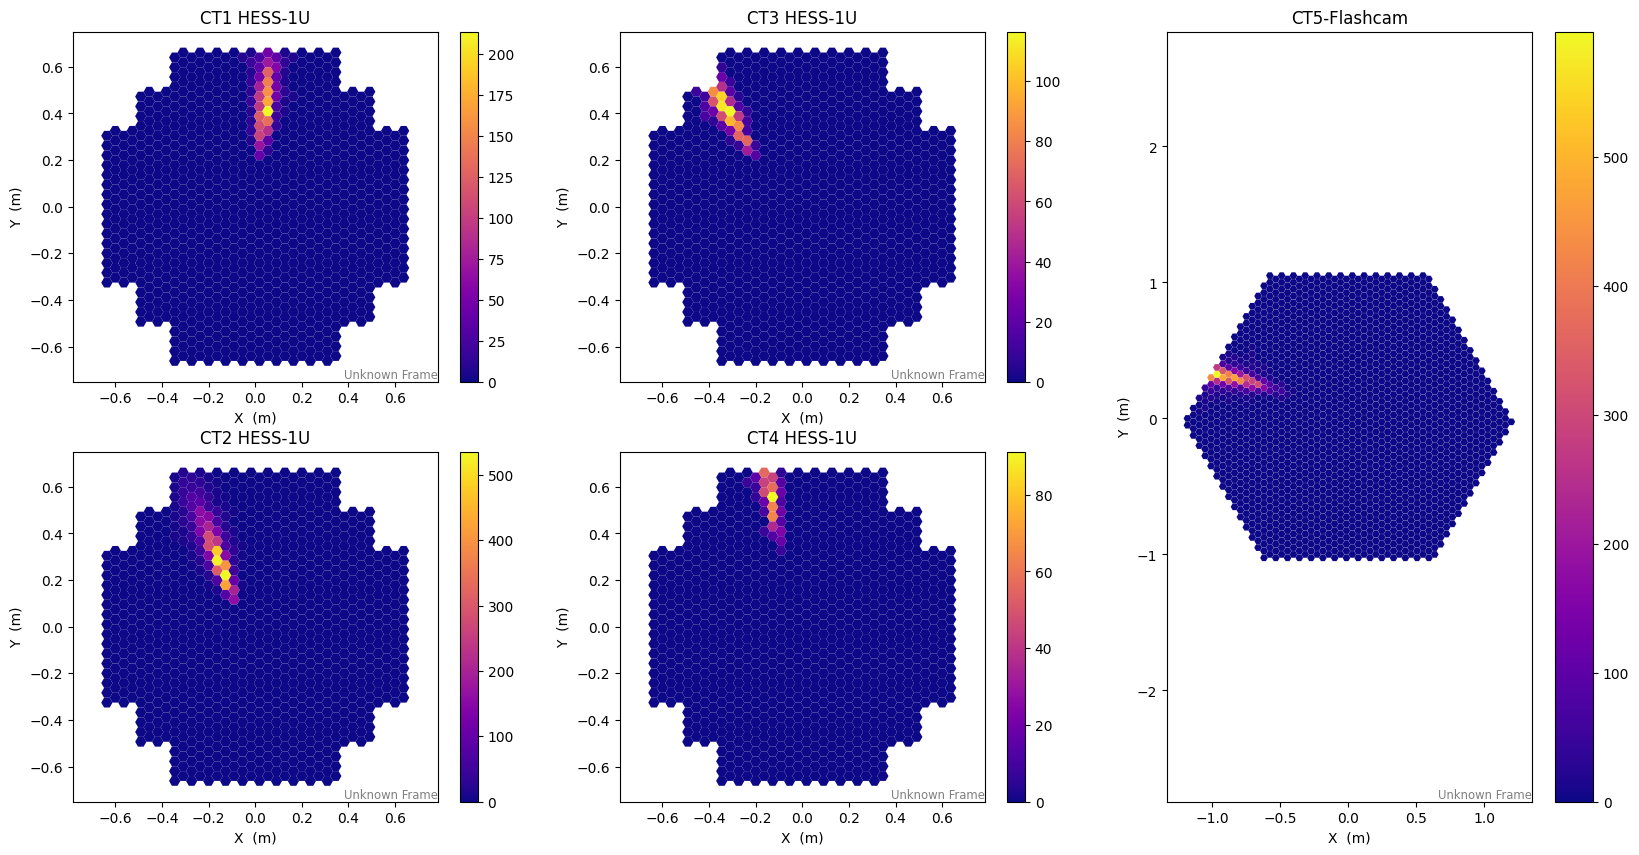

In [18]:
i=3
DisplayEvent(EnergyCut,EnergyCut.Event_loop_id.drop_duplicates().values[i],colormap="plasma")

## Highlighting Shower pixels (= pixels that survive the cleaning)

 Event 161203.0:
 -----> MC Energy = 19.959800 TeV, CorePoint = (266.028000,-65.064300) m


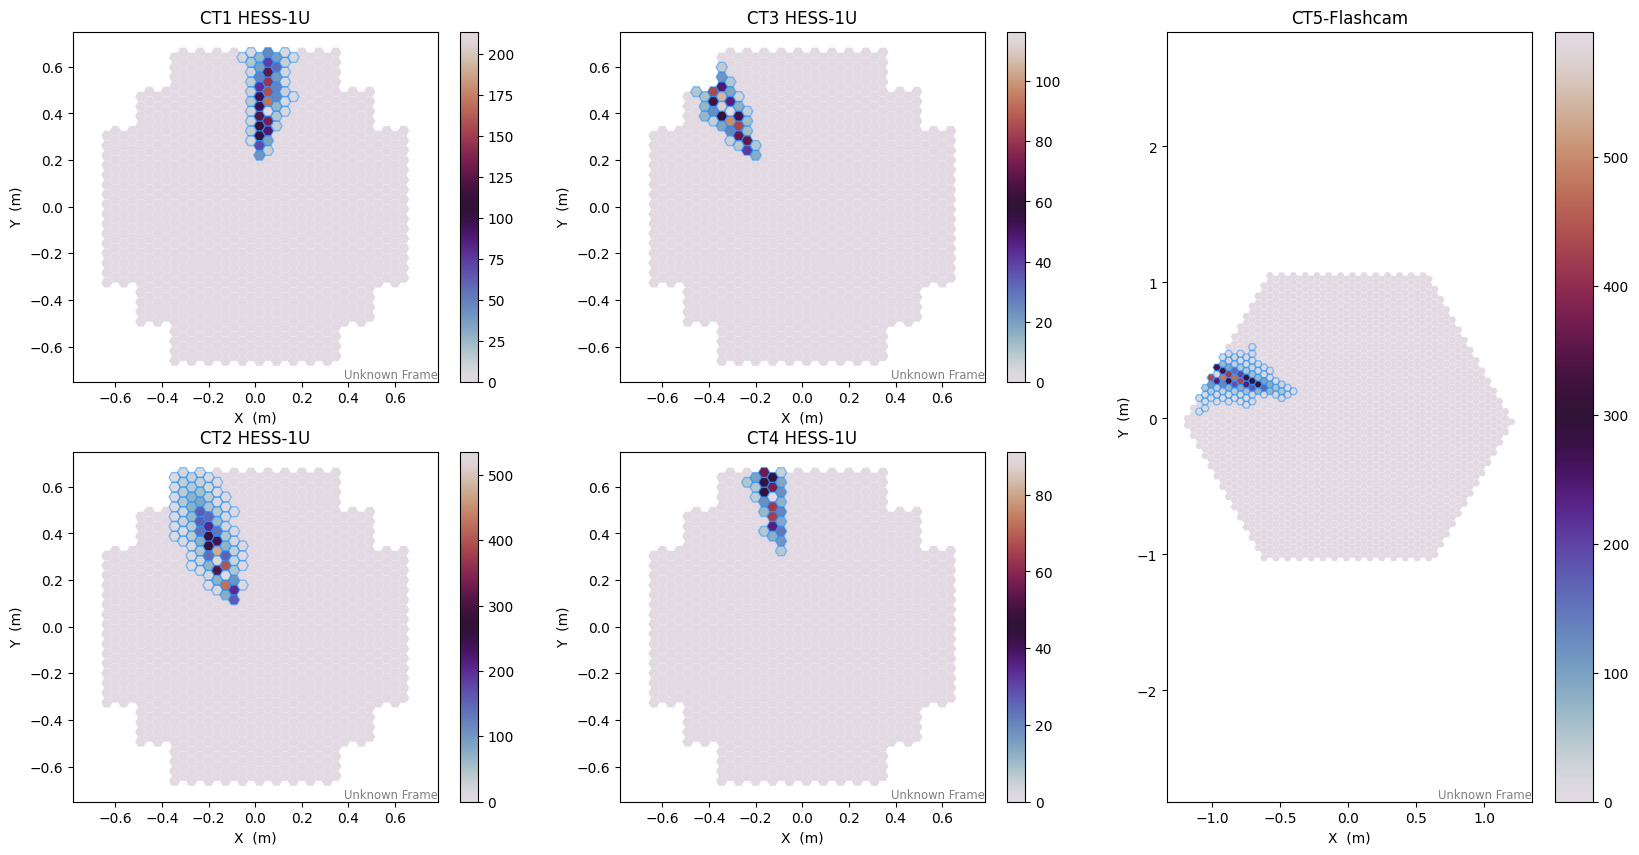

In [19]:
DisplayEvent(EnergyCut,EnergyCut.Event_loop_id.drop_duplicates().values[i],highlight_cleaned_pixels=True)

## Extracting Hillas parameters from images

 Event 161203.0:
 -----> MC Energy = 19.959800 TeV, CorePoint = (266.028000,-65.064300) m


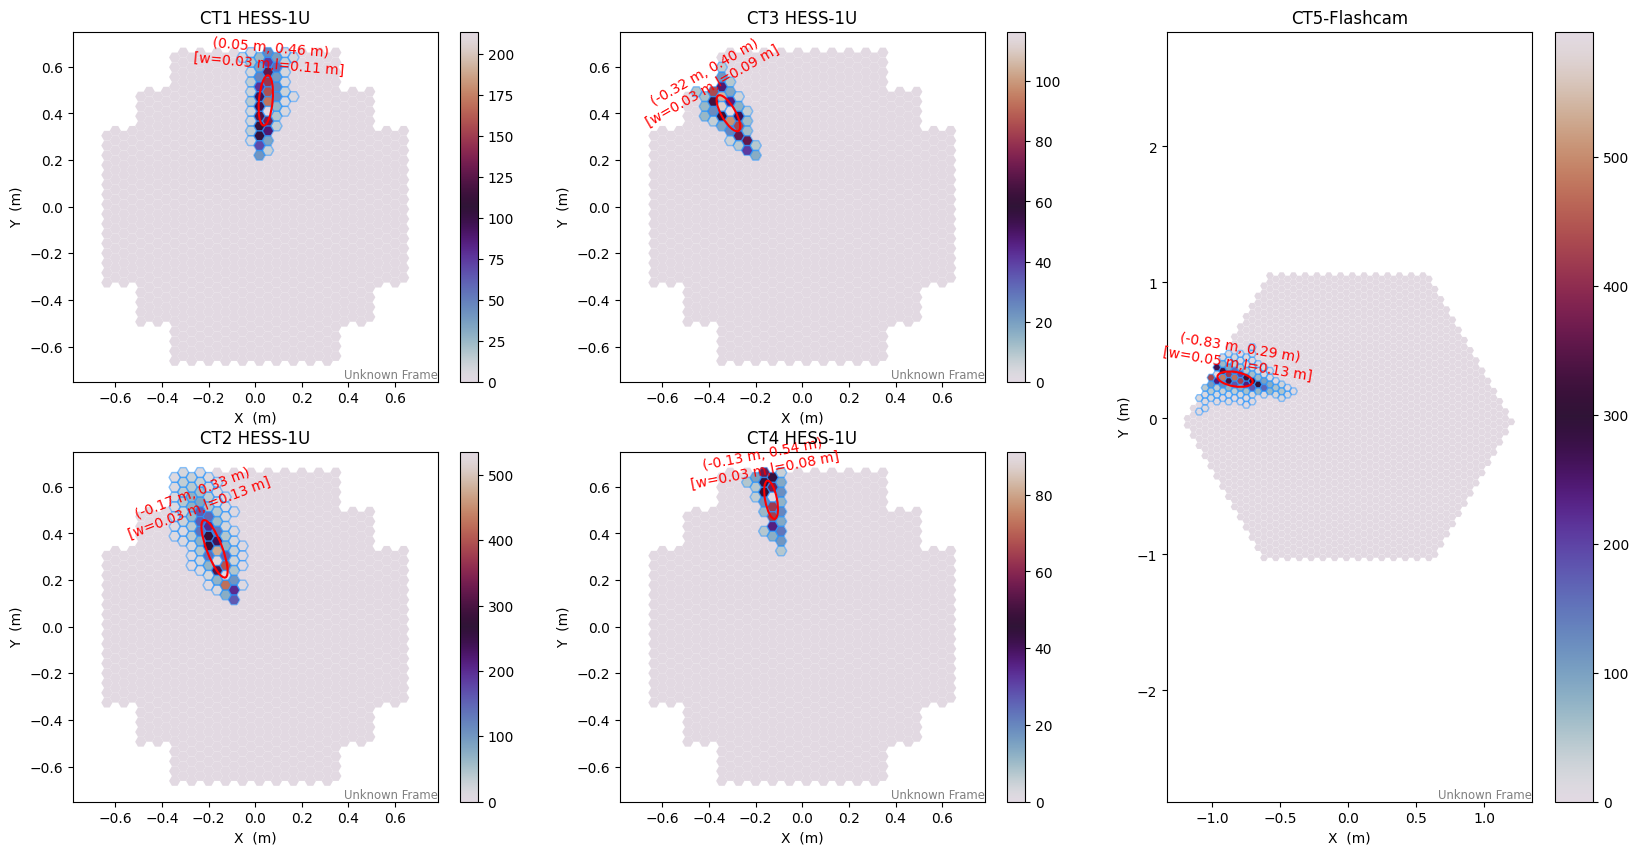

In [20]:
DisplayEvent(EnergyCut,EnergyCut.Event_loop_id.drop_duplicates().values[i],highlight_cleaned_pixels=True,HillasParameters=True)

## Animations